# Decoding Vehicle Data with Machine Learning

- By: Austin Jenkins
- Class: Unsupervised Algorithms in Machine Learning

## Table of Contents
1. Table of Contents
2. Introduction
3. EDA - Exploratory Data Analysis
4. Create Test Data
5. Word Embedding
6. Unsupservised Learning
7. Predicting Missing Values with Supervised Learning
8. Conclusion
9. References

## Introduction

### Background
I have a small company that I run as a project that gathers information about GM vehicles.  Within this company, we parse PDF invoices and extract important information from them.  Since this data comes across as a list of strings, we need to convert this data into a structured format.  I've been doing this in PHP and extracting the data based on the position of the data in the string.  This can sometimes lead to incorrect results.  So, I want to try to use machine learning to extract the data from the strings and fill in any missing parts.

### About the Data

I currently have a MySQL database that contains many tables, but the one we're most interested in is the `vehicles` table.  This table contains the following columns:
- vin - A 17 digit string that is unique to each vehicle
- year - The year the vehicle was made
- make - The make of the vehicle (ex: Chevrolet, GMC, etc.)
- peg_rpo_code - A 3 digit string code that represents the vehicle's trim level
- peg_description - A description of the vehicle's trim level
- exterior_color_rpo_code - A 3 digit string code that represents the vehicle's exterior color
- exterior_color_description - A description of the vehicle's exterior color
- interior_color_rpo_code - A 3 digit string code that represents the vehicle's interior color
- interior_color_description - A description of the vehicle's interior color
- engine_rpo_code - A 3 digit string code that represents the vehicle's engine
- engine_description - A description of the vehicle's engine
- transmission_rpo_code - A 3 digit string code that represents the vehicle's transmission
- transmission_description - A description of the vehicle's transmission

This data does not include the long string from the PDF of the vehicle.  To add this in, I had to write a script within the app which was written in PHP to convert the PDF to a string and append it to each.  This process took quite a while to run.  Within this script I had it output to a csv so that we can use it for our modeling.  This csv is located within the /data/train.csv folder of this repository.

We started collecting this data in 2019 so the data is quite large considering the invoice string is long.  The initial data set is XXX columns and a total size of YYY.

### Problem Description

Given the long string of the invoice, we want to predict the missing values in the `vehicles` table.  We will use the `train.csv` file to train our model and the `test.csv` file to test our model. 

## EDA - Exploratory Data Analysis

### Load The Data and Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import nltk

from collections import Counter
from nltk.corpus import stopwords

from IPython.display import display, HTML

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.metrics import root_mean_squared_error, accuracy_score, classification_report, precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier

In [2]:
train_data_frame = pd.read_csv("data/output.csv")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Initial Data Inspection

In [3]:
print(train_data_frame.info())
print(train_data_frame.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21033 entries, 0 to 21032
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   vin                         21032 non-null  object 
 1   year                        21032 non-null  float64
 2   make                        20753 non-null  object 
 3   peg_rpo_code                21033 non-null  object 
 4   peg_description             21033 non-null  object 
 5   exterior_color_rpo_code     21032 non-null  object 
 6   exterior_color_description  21032 non-null  object 
 7   interior_color_rpo_code     20997 non-null  object 
 8   interior_color_description  20997 non-null  object 
 9   engine_rpo_code             20719 non-null  object 
 10  engine_description          20719 non-null  object 
 11  transmission_rpo_code       21029 non-null  object 
 12  transmission_description    21029 non-null  object 
 13  invoice                     210

As we can see, there's an initial count of 21,033 entries.  However, I suspect there are some duplicates and potential missing values in the vin column.  This is our primary unique identifier so we need to make sure that there are no duplicates.

Next, we'll take a look at the breakdown of the makes.

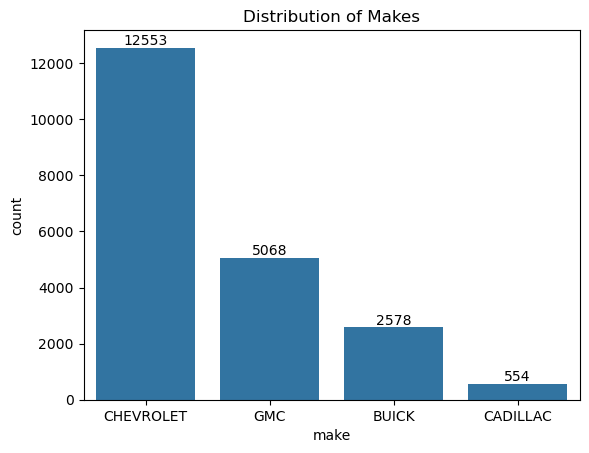

In [4]:
graph = sns.countplot(data=train_data_frame, x='make', order=train_data_frame['make'].value_counts().index) 

for i in graph.containers:
    graph.bar_label(i, label_type='edge')

plt.title("Distribution of Makes")
plt.show()


Next I'll take a look at the top words in the invoice strings.  This will help me identify any words that are not helpful to the model.  If there are some, I can remove those during data clean up.

In [5]:
invoice_text = " ".join(train_data_frame['invoice'].fillna(""))
word_counts = Counter(invoice_text.split()).most_common(50)
word_counts_df = pd.DataFrame(word_counts, columns=["Word", "Frequency"])
display(word_counts_df.style.set_table_attributes("style='display:inline'").set_caption("Top 50 Words in Invoice Column"))


,Word,Frequency
0,N/C,159078
1,*,146882
2,OF,70447
3,INVOICE,70407
4,TOTAL,65316
5,&,62673
6,AND,57234
7,CREDIT,54540
8,NO.,51728
9,STOCK,51525


As we can see, there is a lot of generic words in there.  I'll do some data clean up and try to remove these words that could affect the performance of the model.  I'll go ahead and create a list of these words and remove them from the invoice strings.

In [6]:
custom_stop_words = {
    'NC',
    'INVOICE',
    'TOTAL',
    'DEALER',
    'CREDIT',
    'STOCK',
    'VEHICLE',
    'MODEL',
    'OPTIONS',
    'HOLDBACK',
    'XXXXX',
    'FINANCE',
    'EXP',
    '261',
    'CONTRIBUTION',
    'PACKAGE',
    'LLC',
    'MOTORS',
    'MSRP',
    'FACTORY',
    'VIN',
    'INV',
    'MI',
    'DETROIT',
    'GENERAL',
    'RENAISSANCE',
    'ORDER',
    'AMT',
    'RETAIL',
    'GVWR',
    'ALERT',
    'BANK',
    'COST',
    'WT',
    'CHARGE',
    'ULTIMATE',
    'SHIP',
    'PRC',
    'SHIPPED',
    'EFF',
    'CHGTO',
    'HP',
    'DESTINATION',
    '482431114',
    'act',
    'reflect',
    'dealers',
    'manufacturer',
    'rebates',
    'allowances',
    'incentives',
    'return',
    'advertising',
    'monies',
    'may',
    'apply',
    'com',
    'int',
    'keys',
    '310',
    'pay',
    'memo',
    'less',
    'employ',
    'supplr',
    'empinc',
    'supinc',
    '237',
    'emissions',
    'gawrft',
    'gawrrr',
    'approx',
    'wholesale',
    'hb',
    '50state',
    'adv',
    'group',
    'qtr',
    'opt1',
    '65a',
    'transmission',
    'engine',
}



### Clean The Data
 - Remove Duplicates from the vin (first determine how many duplicates there are)
 - Remove irrelevant characters from the invoice column
 - Remove empty invoice rows
 - Remove rows where the invoice column includes the word "available"
 - Remove stop words

In [7]:
def data_cleanup(data_frame):
    """
    Helper function to help with cleaning the data
    """

    data_frame['invoice'] = data_frame['invoice'].str.replace(r'[^\w\s]', '', regex=True).str.upper()
    data_frame = data_frame.dropna(subset=['vin', 'invoice', 'peg_rpo_code'])
    data_frame = data_frame.drop_duplicates(subset='vin')

    return data_frame


def remove_stop_words(text):
    """
    Removes stop words from a given text.
    """
    if isinstance(text, str):

        stop_words = set(word.lower() for word in stopwords.words('english'))
        lower_case_custom_stop_words = set(word.lower() for word in custom_stop_words)
        stop_words = stop_words.union(lower_case_custom_stop_words)

        text = re.sub(r'[^\w\s]', '', text)
        text = text.lower()
        
        words = text.split()
        cleaned_text = ' '.join(word for word in words if word not in stop_words)

        return cleaned_text

    return text

train_data_frame = data_cleanup(train_data_frame)
train_data_frame['invoice'] = train_data_frame['invoice'].apply(remove_stop_words)
print(train_data_frame.info())
print(train_data_frame.head())

<class 'pandas.core.frame.DataFrame'>
Index: 17347 entries, 0 to 21032
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   vin                         17347 non-null  object 
 1   year                        17347 non-null  float64
 2   make                        17129 non-null  object 
 3   peg_rpo_code                17347 non-null  object 
 4   peg_description             17347 non-null  object 
 5   exterior_color_rpo_code     17346 non-null  object 
 6   exterior_color_description  17346 non-null  object 
 7   interior_color_rpo_code     17322 non-null  object 
 8   interior_color_description  17322 non-null  object 
 9   engine_rpo_code             17097 non-null  object 
 10  engine_description          17097 non-null  object 
 11  transmission_rpo_code       17345 non-null  object 
 12  transmission_description    17345 non-null  object 
 13  invoice                     17347 no

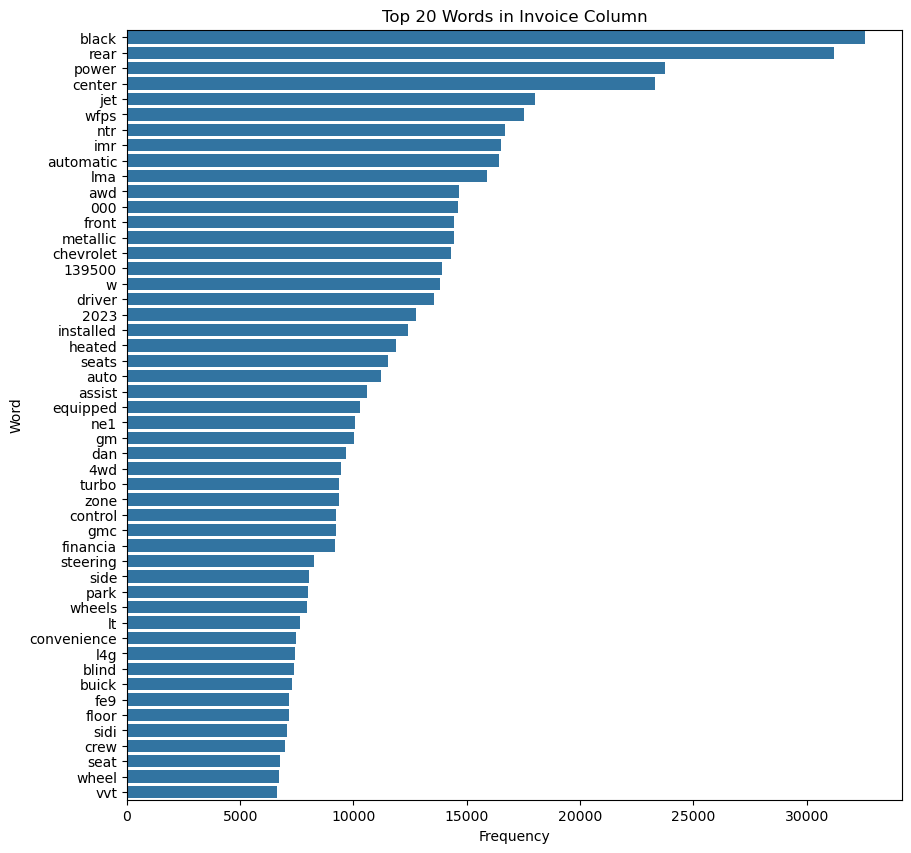

In [8]:
invoice_text = " ".join(train_data_frame['invoice'].fillna(""))

word_counts = Counter(invoice_text.split()).most_common(50)

words, counts = zip(*word_counts)

plt.figure(figsize=(10, 10))
sns.barplot(x=list(counts), y=list(words), orient='h')
plt.title("Top 20 Words in Invoice Column")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()


### Visualizations of Data

#### Categorical Distributions

Here I'd like to see the distribution of the categorical data.  This will help us understand the data better and see if there are any potential outliers.

In [9]:
def generate_top20_tables(df, count_column):
    """
    Calculates and returns the data I can use to generate the top 20 tables.
    """
    tables = {}
    for make, group in df.groupby('make'):
        counts = group[count_column].value_counts()

        top_20 = counts.head(20).reset_index()
        top_20.columns = [count_column, 'Count']
        top_20['Rank'] = np.arange(1, len(top_20) + 1)
        top_20['Percentage'] = ((top_20['Count'] / counts.sum()) * 100).round(2)

        others_sum = counts.iloc[20:].sum()
        if others_sum > 0:
            others_row = {
                count_column: 'Others',
                'Count': others_sum,
                'Rank': '21+',
                'Percentage': round((others_sum / counts.sum()) * 100, 2)
            } 
            top_20 = pd.concat([top_20, pd.DataFrame([others_row])], ignore_index=True)

        tables[make] = top_20

    return tables


def display_tables_side_by_side(tables):
    """
    Just a helper function to display the tables side by side.
    """
    html = f"<div style='display:flex; justify-content:space-around;'>"
    for make, table in tables.items():
        html += f"<div><h3>{make}</h3>{table.to_html(index=False)}</div>"
    html += "</div>"
    display(HTML(html))

tables = generate_top20_tables(train_data_frame, 'peg_rpo_code')
display_tables_side_by_side(tables)

tables = generate_top20_tables(train_data_frame, 'exterior_color_rpo_code')
display_tables_side_by_side(tables)





peg_rpo_code,Count,Rank,Percentage
1SL,716,1,34.10
1SB,363,2,17.29
1SD,343,3,16.33
1SU,258,4,12.29
1SC,136,5,6.48
1SP,130,6,6.19
1SN,70,7,3.33
G02,32,8,1.52
G03,32,9,1.52
G04,20,10,0.95


exterior_color_rpo_code,Count,Rank,Percentage
GAZ,402,1,19.14
GB8,213,2,10.14
GB0,161,3,7.67
GZB,142,4,6.76
GFM,141,5,6.71
GEJ,129,6,6.14
GP5,89,7,4.24
GZA,84,8,4.00
GXD,81,9,3.86
G1W,80,10,3.81


## Create Test Data

Because I only have the training data that I created from my other app, I will need some test data for evaluation.  I am going to use the train_test_split function from sklearn to split the data into a training and testing set.

I do not want to include the rpo_columns in the test data, because these are what I want the model(s) to predict.  With that said, I am going to store two versions of the test data: one with the labels and one without.

In [10]:
train_data_frame, test_data_frame = train_test_split(train_data_frame, test_size=0.2, random_state=42)

rpo_columns = ['peg_rpo_code', 'exterior_color_rpo_code', 'interior_color_rpo_code', 
               'engine_rpo_code', 'transmission_rpo_code']

test_data_with_labels = test_data_frame.copy()
test_data_no_labels = test_data_frame.drop(columns=rpo_columns)

## Word Embedding

TF-IDF

In [11]:
def tfidf_vectorize(train_texts, test_texts, max_features=20000):
    """
    Vectorize the text data using TF-IDF.
    """
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        stop_words="english",
        lowercase=True,
    )
    train_tfidf = vectorizer.fit_transform(train_texts)
    test_tfidf = vectorizer.transform(test_texts)
    print(f"TF-IDF matrix created with shape: {train_tfidf.shape}")
    return train_tfidf, test_tfidf, vectorizer


In [12]:
def analyze_tfidf(tfidf_matrix, feature_names, top_n=20, title="Top TF-IDF Features"):
    """
    Perform EDA on TF-IDF matrix and visualize top terms by average TF-IDF score.
    """
    avg_tfidf_scores = np.mean(tfidf_matrix.toarray(), axis=0)
    
    top_indices = np.argsort(avg_tfidf_scores)[-top_n:][::-1]
    top_terms = [feature_names[i] for i in top_indices]
    top_scores = avg_tfidf_scores[top_indices]
    
    plt.figure(figsize=(10, 10))
    plt.barh(top_terms[::-1], top_scores[::-1])
    plt.xlabel("Average TF-IDF Score")
    plt.ylabel("Terms")
    plt.title(title)
    plt.show()


In [13]:
def plot_tsne(embeddings, labels, title="t-SNE Visualization"):
    """
    Reduce the dimensionality of embeddings using t-SNE and plot.
    """
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, init='random')
    reduced_vectors = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 10))
    for label in set(labels):
        indices = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(reduced_vectors[indices, 0], reduced_vectors[indices, 1], label=label, alpha=0.7)
    plt.legend()
    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

In [14]:
def main_tfidf_analysis_by_make(train_data_frame, test_data_frame, max_features=20000, top_n=20):
    """
    Pipeline for generating and analyzing TF-IDF matrices grouped by 'make'.
    """
    unique_makes = train_data_frame["make"].dropna().unique()
    
    for make in unique_makes:
        
        train_subset = train_data_frame[train_data_frame["make"] == make]
        test_subset = test_data_frame[test_data_frame["make"] == make]
        
        if train_subset.empty or test_subset.empty:
            continue

        train_tfidf, test_tfidf, vectorizer = tfidf_vectorize(
            train_subset["invoice"], test_subset["invoice"], max_features=max_features
        )

        feature_names = vectorizer.get_feature_names_out()

        analyze_tfidf(
            train_tfidf, feature_names, top_n=top_n,
            title=f"Top TF-IDF Features for Make: {make}"
        )

        tfidf_matrix_normalized = normalize(train_tfidf, norm="l2", axis=1)

        plot_tsne(
            tfidf_matrix_normalized,
            train_subset["peg_rpo_code"],
            title=f"t-SNE of TF-IDF Embeddings for Make: {make}"
        )

        return vectorizer


TF-IDF matrix created with shape: (8263, 20000)


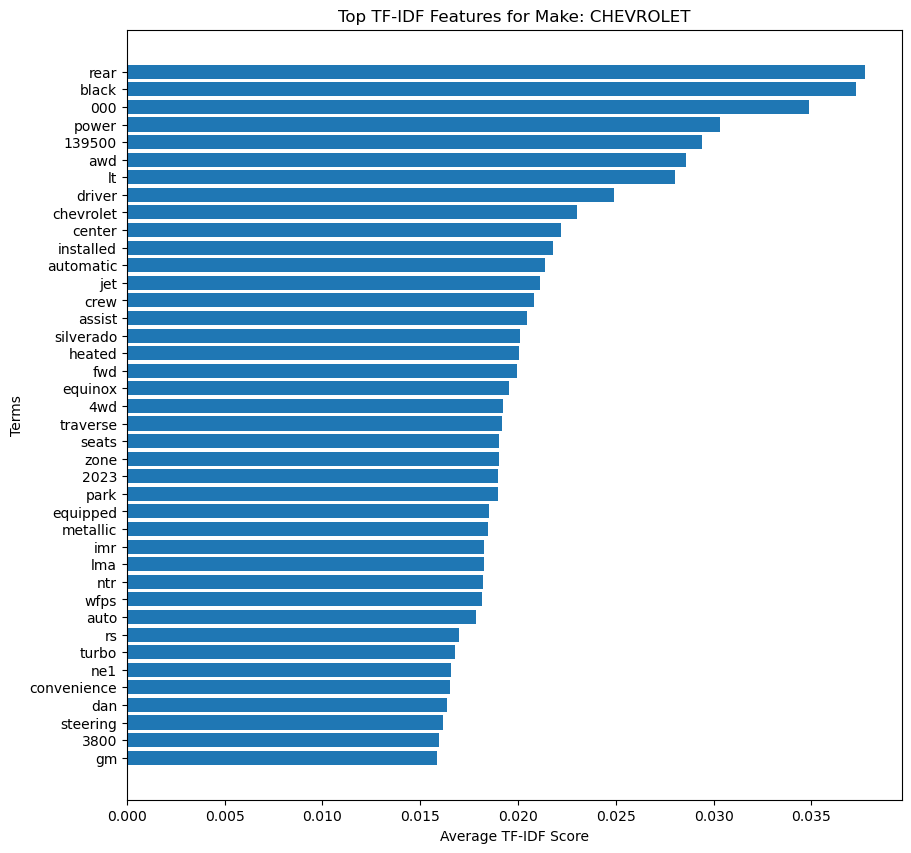

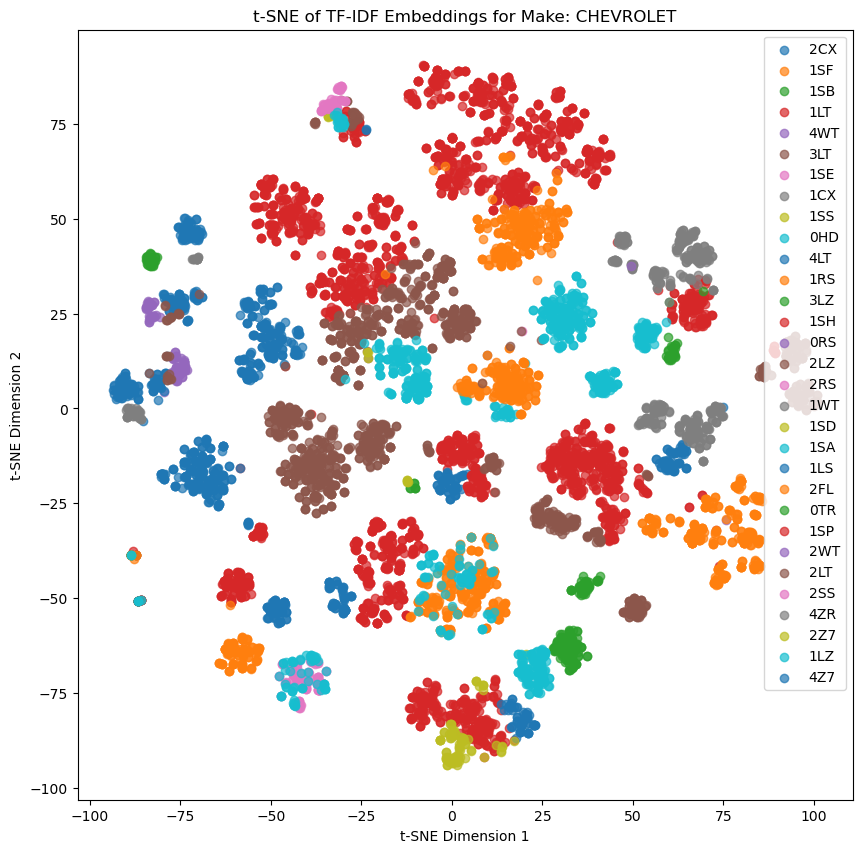

In [15]:
train_data_frame_tfidf = train_data_frame.copy()
test_data_frame_tfidf = test_data_frame.copy()

vectorizer = main_tfidf_analysis_by_make(
    train_data_frame=train_data_frame_tfidf,
    test_data_frame=test_data_frame_tfidf,
    max_features=20000,
    top_n=40
)


## Modeling

### Unsupervised - NMF - Non-Negative Matrix Factorization

I decided to start with NMF because it's a good way to extract features from the data and we had some previous experience using this in the week 4 assignment of the class.

In [16]:
def nmf_modeling(train_tfidf, test_tfidf, n_components=10, random_state=42):
    """
    Train NMF model on training data and transform both train and test data.
    """
    nmf_model = NMF(n_components=n_components, random_state=random_state)
    
    train_nmf = nmf_model.fit_transform(train_tfidf)
    test_nmf = nmf_model.transform(test_tfidf)
    
    test_reconstructed = np.dot(test_nmf, nmf_model.components_)
    test_rmse = root_mean_squared_error(test_tfidf.toarray(), test_reconstructed)
    
    return nmf_model, train_nmf, test_nmf, test_rmse

In [17]:
def summarize_components(nmf_model, feature_names, n_top_features=10):
    """
    Summarize NMF components into key terms and potential themes.
    """
    components = nmf_model.components_
    summary = []

    for i, component in enumerate(components):
        top_features_indices = component.argsort()[-n_top_features:][::-1]
        top_features = [feature_names[idx] for idx in top_features_indices]

        theme_description = f"Key features: {', '.join(top_features[:5])}..."
        summary.append({"Component": i + 1, "Theme": theme_description})

    return pd.DataFrame(summary)


In [18]:
def main_nmf_analysis(train_data_frame, test_data_frame, max_features=20000, n_components=10, n_top_features=10):
    """
    Perform NMF modeling and analysis on the entire dataset and output structured results.
    """
    train_tfidf, test_tfidf, vectorizer = tfidf_vectorize(
        train_data_frame["invoice"], test_data_frame["invoice"], max_features=max_features
    )

    nmf_model, train_nmf, test_nmf, test_rmse = nmf_modeling(
        train_tfidf, test_tfidf, n_components=n_components
    )

    feature_names = vectorizer.get_feature_names_out()
    component_analysis = summarize_components(nmf_model, feature_names, n_top_features=n_top_features)

    results_summary = {
        "Train TF-IDF Shape": train_tfidf.shape,
        "Test TF-IDF Shape": test_tfidf.shape,
        "Test RMSE": test_rmse
    }

    return results_summary, component_analysis, train_nmf, test_nmf, nmf_model


### RMSE, Hyperparameter Tuning & Optimizations

In [19]:
def hyperparameter_tuning(train_data_frame, test_data_frame, parameter_list, fixed_parameters, parameter_name):
    """
    Perform hyperparameter tuning for NMF and visualize RMSE values for a single parameter.
    """
    results = []

    for param_value in parameter_list:
        current_params = fixed_parameters.copy()
        current_params[parameter_name] = param_value

        try:
            results_summary, _, _, _, _ = main_nmf_analysis(
                train_data_frame=train_data_frame,
                test_data_frame=test_data_frame,
                max_features=current_params["max_features"],
                n_components=current_params["n_components"],
                n_top_features=current_params["n_top_features"]
            )

            results.append({
                parameter_name: param_value,
                "Test RMSE": results_summary["Test RMSE"]
            })

        except Exception as e:
            print(f"Error with {parameter_name}={param_value}: {e}")
            continue

    results_df = pd.DataFrame(results)

    plt.figure(figsize=(12, 6))
    plt.plot(results_df[parameter_name], results_df["Test RMSE"], marker='o', label=f'Tuning {parameter_name}')
    
    for i, row in results_df.iterrows():
        plt.annotate(
            f"{row['Test RMSE']:.4f}",
            (row[parameter_name], row["Test RMSE"]),
            textcoords="offset points",
            xytext=(0, 10),
            ha="center"
        )

    plt.title(f"RMSE vs {parameter_name}")
    plt.xlabel(parameter_name)
    plt.ylabel("Test RMSE")
    plt.grid(True)
    plt.legend()
    plt.show()

    return results_df


### Optimizing # Max Features

TF-IDF matrix created with shape: (13877, 10000)
TF-IDF matrix created with shape: (13877, 20000)
TF-IDF matrix created with shape: (13877, 30000)
TF-IDF matrix created with shape: (13877, 40000)
TF-IDF matrix created with shape: (13877, 50000)
TF-IDF matrix created with shape: (13877, 60000)
TF-IDF matrix created with shape: (13877, 70000)
TF-IDF matrix created with shape: (13877, 80000)
TF-IDF matrix created with shape: (13877, 90000)


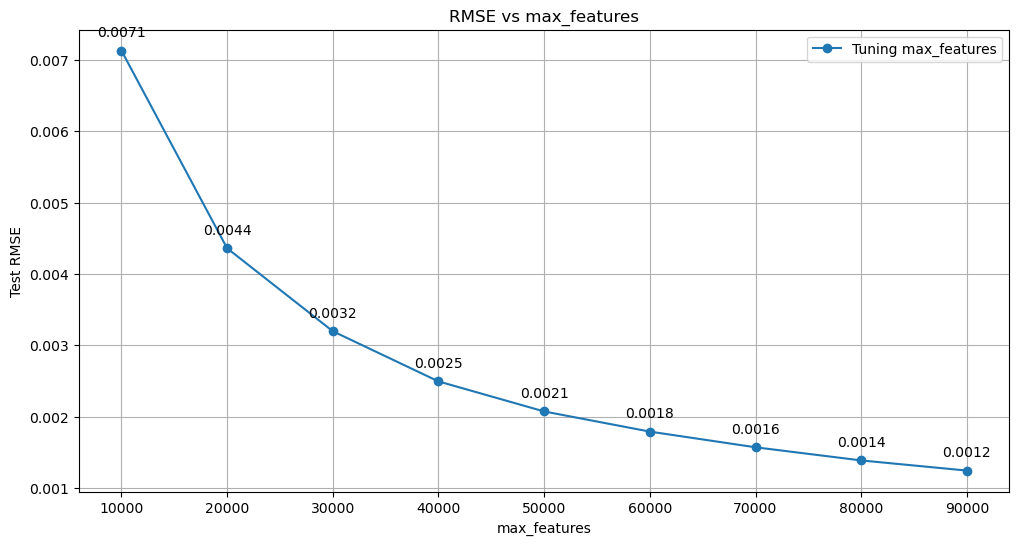

In [20]:
max_features_list = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000]
fixed_params = {"n_components": 10, "n_top_features": 10}

tuning_results = hyperparameter_tuning(
    train_data_frame=train_data_frame_tfidf,
    test_data_frame=test_data_frame_tfidf,
    parameter_list=max_features_list,
    fixed_parameters=fixed_params,
    parameter_name="max_features"
)

In [21]:
n_features = 60000

As we can see, the RMSE does decrease with the number of features.  However, the drop seems to level off around 50,000.  The more features we add the more it will take to run the model.  So, I dediced to settle on 60,000 features, which gives me a an RMSE of less than .002.

### Optimizing # of Components

I wanted to run a couple different tests on the n_components, but it's taking far too long to run, so I am sticking with 10 components.  And, after we've already run the updates on the max_features, we're getting a pretty good RMSE.

In [22]:
n_components = 10

### Optimizing # of Top Features

TF-IDF matrix created with shape: (13877, 60000)
TF-IDF matrix created with shape: (13877, 60000)
TF-IDF matrix created with shape: (13877, 60000)
TF-IDF matrix created with shape: (13877, 60000)


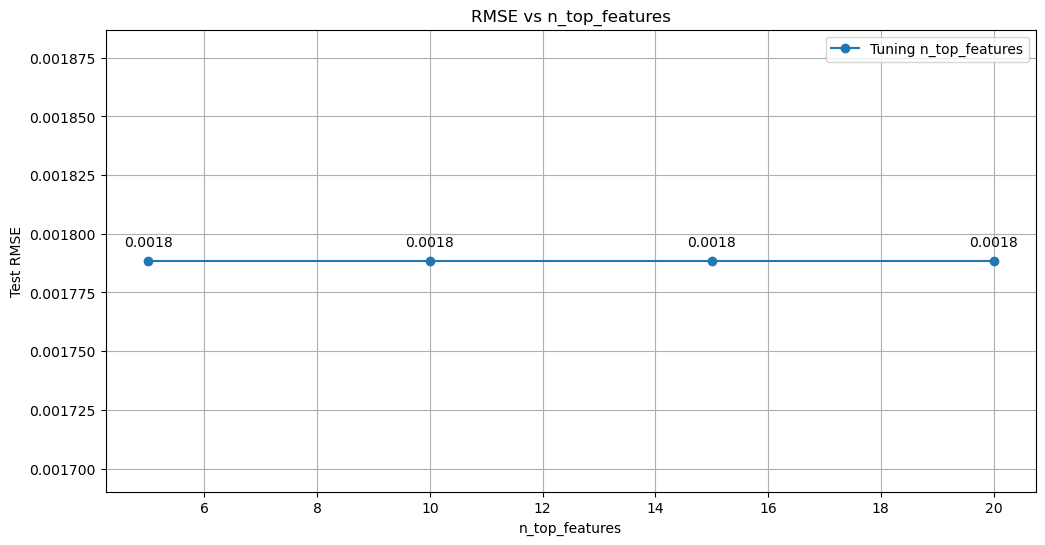

In [23]:
max_features_list = [5, 10, 15, 20]
fixed_params = {"n_components": n_components, "max_features": n_features}

tuning_results = hyperparameter_tuning(
    train_data_frame=train_data_frame_tfidf,
    test_data_frame=test_data_frame_tfidf,
    parameter_list=max_features_list,
    fixed_parameters=fixed_params,
    parameter_name="n_top_features"
)

As we can see, adjusting the n_top_features doesn't change the RMSE at all, so I'll stick with just 5.

In [24]:
n_top_features=5

### Final Model

In [25]:
train_tfidf, test_tfidf, vectorizer = tfidf_vectorize(
    train_texts=train_data_frame["invoice"],
    test_texts=test_data_frame["invoice"],
    max_features=n_features
)

nmf_model, train_nmf, test_nmf, test_rmse = nmf_modeling(
    train_tfidf=train_tfidf,
    test_tfidf=test_tfidf,
    n_components=n_components
)

results_summary, component_analysis, train_nmf, test_nmf, nmf_model = main_nmf_analysis(
    train_data_frame=train_data_frame,
    test_data_frame=test_data_frame,
    max_features=n_features,
    n_components=n_components,
    n_top_features=n_top_features
)


TF-IDF matrix created with shape: (13877, 60000)
TF-IDF matrix created with shape: (13877, 60000)


## Predicting the Missing Values with Supervised Random Forest

In [26]:
def evaluate_nmf_predictions(train_data_frame, test_data_frame, target_columns, nmf_model, vectorizer):
    """
    Evaluate the accuracy of NMF-transformed features in predicting given target columns.
    """
    results = []
    for target in target_columns:
        print(f"Evaluating Predictions for {target}...")

        train_data_frame = train_data_frame.dropna(subset=[target]).reset_index(drop=True)
        test_data_frame = test_data_frame.dropna(subset=[target]).reset_index(drop=True)

        train_tfidf = vectorizer.transform(train_data_frame["invoice"])
        test_tfidf = vectorizer.transform(test_data_frame["invoice"])

        train_nmf = nmf_model.transform(train_tfidf)
        test_nmf = nmf_model.transform(test_tfidf)

        train_labels = train_data_frame[target].astype(str)
        test_labels = test_data_frame[target].astype(str)

        if len(train_labels) != train_nmf.shape[0] or len(test_labels) != test_nmf.shape[0]:
            raise ValueError(f"Mismatch in shapes for target '{target}': Train NMF {train_nmf.shape}, Train Labels {len(train_labels)}")

        clf = RandomForestClassifier(class_weight="balanced", random_state=42)
        clf.fit(train_nmf, train_labels)
        predicted_labels = clf.predict(test_nmf)

        accuracy = accuracy_score(test_labels, predicted_labels)
        precision = precision_score(test_labels, predicted_labels, average="weighted", zero_division=0)
        recall = recall_score(test_labels, predicted_labels, average="weighted", zero_division=0)
        f1 = f1_score(test_labels, predicted_labels, average="weighted", zero_division=0)

        results.append({
            "Target": target,
            "Accuracy": accuracy,
            "Weighted Precision": precision,
            "Weighted Recall": recall,
            "Weighted F1-Score": f1
        })
    
    results_df = pd.DataFrame(results)
    return results_df


In [27]:
target_columns = [
    "peg_rpo_code",
    "exterior_color_rpo_code",
    "interior_color_rpo_code",
    "engine_rpo_code",
    "transmission_rpo_code",
]

evaluation_results = evaluate_nmf_predictions(
    train_data_frame=train_data_frame,
    test_data_frame=test_data_frame,
    target_columns=target_columns,
    nmf_model=nmf_model,
    vectorizer=vectorizer
)

print("\nSummary of Accuracy by Target Column:")
print(evaluation_results)


Evaluating Predictions for peg_rpo_code...
Evaluating Predictions for exterior_color_rpo_code...
Evaluating Predictions for interior_color_rpo_code...
Evaluating Predictions for engine_rpo_code...
Evaluating Predictions for transmission_rpo_code...

Summary of Accuracy by Target Column:
                    Target  Accuracy  Weighted Precision  Weighted Recall  \
0             peg_rpo_code  0.835447            0.848919         0.835447   
1  exterior_color_rpo_code  0.461805            0.446340         0.461805   
2  interior_color_rpo_code  0.774156            0.769040         0.774156   
3          engine_rpo_code  0.884829            0.886856         0.884829   
4    transmission_rpo_code  0.887135            0.891380         0.887135   

   Weighted F1-Score  
0           0.835669  
1           0.442849  
2           0.759780  
3           0.883441  
4           0.883551  


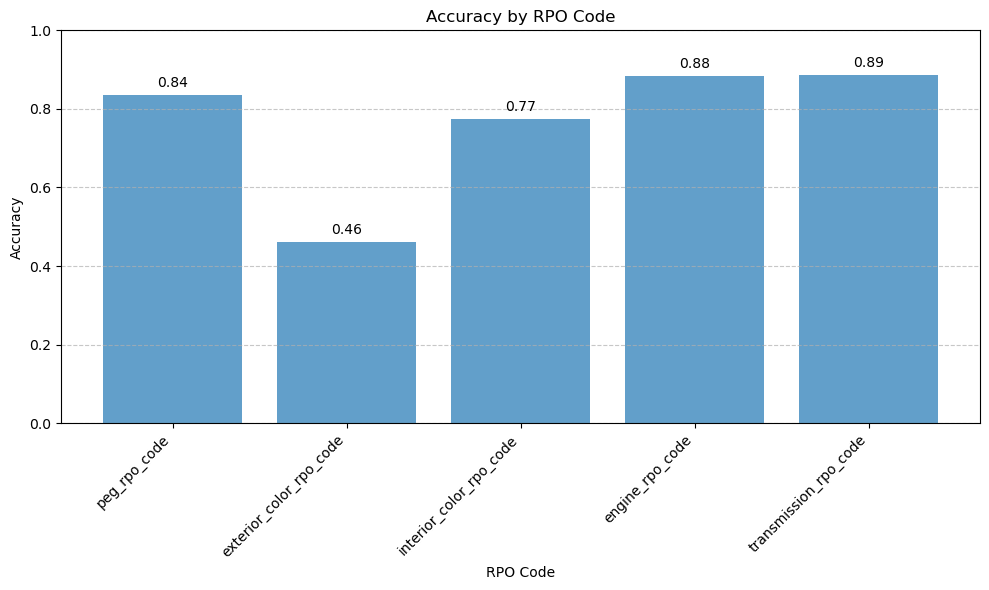

In [28]:
plt.figure(figsize=(10, 6))
plt.bar(evaluation_results["Target"], evaluation_results["Accuracy"], alpha=0.7)
plt.title("Accuracy by RPO Code")
plt.xlabel("RPO Code")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

for idx, value in enumerate(evaluation_results["Accuracy"]):
    plt.text(idx, value + 0.02, f"{value:.2f}", ha="center")

plt.tight_layout()
plt.show()


## Conclusion


### Performance Evaluation

- <strong>peg_rpo_code</strong>: Got the highest accuracy of 83.54%. This shows strong performance in predicting this code from the invoice data.
- <strong>engine_rpo_code and transmission_rpo_code</strong>: Delivered pretty decent accuracies of 88.48% and 88.71%. This means there is a decent relationship between the invoice text.
- <strong>interior_color_rpo_code</strong>: Scored an ok accuracy of 77.42%, indicating room for improvement but capturing relevant patterns.
- <strong>exterior_color_rpo_code</strong>: Achieved a poor (at least in my opinion) accuracy of 46.18%.  I'm surprised by this and would like to try to increase it in the future.

Overall, the model performed reasonably well on most RPO codes, especially for the engine and transmission rpo codes.

### Ideas for Future Enhancements

- <strong>Improving Feature Representation</strong>: Explore other text representation methods such as word embeddings (e.g., Word2Vec or GloVe) to capture contextual relationships in the invoice text.  I chose TF-IDF because we used it in the class and it doesn't depend on context too much.  Afterall, I'm looking at codes that aren't part of normal text, so I thought contextual representations wouldn't be super helpful.  That said, I would be open to trying some of these other word embedding techniques in the future.

- <strong>Incorporate domain-specific knowledge</strong>: I could try providing a dictionary of RPO codes and their descriptions to the model to help it learn the relationships between the codes and the text.  This could help the model learn the relationships between the codes and the text.

- <strong>Ensemble Methods</strong>: Combine predictions from multiple models, such as ensemble techniques using different classifiers (e.g., Gradient Boosting, Support Vector Machines) to improve overall accuracy.

- <strong>Handling Imbalanced Data</strong>: Integrate other features (for example, vehicle make, model year) into the model as additional features, which may help increase the predictive power.

### Final Thoughts
This project highlights did a pretty good job of showing the power of combining unsupervised learning techniques like NMF with predictive models to tackle real-life classification problems. While the results are promising, there is room to refine the approach further, particularly for less predictable RPO codes exterior colors. By incorporating advanced text representation techniques and addressing class imbalances, I can build on this foundation to develop an even more robust (and hopefully accurate) predictive model.

## References